In [1]:
import sys
sys.path.append('../../')

from amplify.client import FixstarsClient
from matplotlib import pyplot as plt
import numpy as np
import os
import tikzplotlib

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator import MeshDiffuser
from optimizer import Annealing, AnnealingSolver
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationProblem

In [2]:
output_path = '/usr2/key/Projects/QuantumAnnealing/TopoFlowManuscript/fig/parameter_study/diffuser/regularizationDissipation'

In [3]:
textwidth_in_inches = 500.484/72.27

In [4]:
# Create Meshes for Diffuser Problem
n_elem_for_width = 32
n_elem_for_height = 32

mesh_v = MeshDiffuser('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDiffuser('Q1', n_elem_for_width, n_elem_for_height)

In [5]:
def inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 4*(1.-y)*y; v_y = 0.0
    return np.array([v_x, v_y])

In [6]:
# Compute boundary velocities.
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet':
            boundary_velocity[boundary].append(inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
        elif boundary == 'outlet':
            # Parallel outflow, i.e., no vertical velocity.
            BC.append([node, 1, 0.0])
boundary_values_v = np.array(BC)

In [7]:
viscosity = 1.0
density = 1.0
alpha_solid = 12.5
epsilon = viscosity/alpha_solid

In [8]:
fem = FEM(mesh_v, mesh_p, viscosity, density, epsilon=epsilon)
fem.set_boudary_values_v(boundary_values_v)

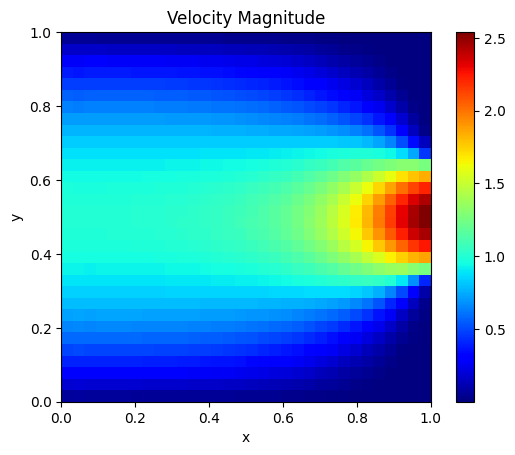

In [9]:
U, u_e, v_e, p_e, F, f = fem.solve()
fem.plot_velocity_magnitude([u_e, v_e])

In [10]:
# Settings for Optimization.
volume_fraction_max = 0.5 # Volume fraction.
design_initial = np.ones(mesh_v.n_elem) # Initial Design.

In [11]:
# Annealing Solver.
client = FixstarsClient()
client.parameters.timeout = 1000
client.parameters.outputs.duplicate = True

if os.path.exists('token_Fixstars.txt'):
    client.token = open('token_Fixstars.txt',"r").read().replace('\n', '')
if os.path.exists('proxy.txt'):
    client.proxy = open('proxy.txt',"r").read().replace('\n', '')
    
annealing_solver = AnnealingSolver(client)

In [12]:
# Topology Optimization Problem
n_qubits_per_variable = 9
hyperparameters = {
    'energy_dissipation': 100.,
    'regularization': 1.,
    'volume_constraint': 20.,
    'char_func': 4.0,
}
topo_opt_problem = TopologyOptimizationProblem(fem.ne, n_qubits_per_variable, hyperparameters, volume_fraction_max)
topo_opt_problem.generate_discretizaton()

In [13]:
# Annealing-Based Optimizer (Two-Step Optimization)
annealing_optimizer = Annealing(fem)
max_opt_steps = 10

In [14]:
# Hyperparameter Study.
lambda_reg_initial = 0.0
lambda_reg_delta = 1.0
n_steps_reg = 5
lambda_reg_values = []

lambda_dis_initial = 0.0
lambda_dis_delta = 25.0
n_steps_dis = 5
lambda_dis_values = []

objective_functions_values = []
volume_fraction_values = []
char_funcs = []


for lambda_dis_i in range(n_steps_dis):
    hyperparameters['energy_dissipation'] = lambda_dis_initial + lambda_dis_i * lambda_dis_delta
    lambda_dis_values.append(hyperparameters['energy_dissipation'])
    print(f' LAMBDA_DIS = {lambda_dis_values[-1]} '.center(80, '#'))
    for lambda_reg_i in range(n_steps_reg):
        hyperparameters['regularization'] = lambda_reg_initial + lambda_reg_i * lambda_reg_delta
        lambda_reg_values.append(hyperparameters['regularization'])
        print(f' LAMBDA_REG = {lambda_reg_values[-1]} '.center(80, '='))



        topo_opt_problem.set_hyperparameters(hyperparameters)
        char_func = annealing_optimizer.optimize(annealing_solver, 
                                    topo_opt_problem,
                                    design_initial, 
                                    max_opt_steps, tol=1e-2)
        objective_functions_values.append(annealing_optimizer.objective_function)
        volume_fraction_values.append(annealing_optimizer.volume_fraction)
        char_funcs.append(char_func)

############################### LAMBDA_DIS = 0.0 ###############################
=============================== LAMBDA_REG = 0.0 ===============================
***************************** Optimization Step 0 ******************************
Objective Function: 0.6451428179419627, Volume Fraction: 0.5
Rel. change in obj. func.: 226.5131962858252
***************************** Optimization Step 1 ******************************
Objective Function: 0.6384931188454699, Volume Fraction: 0.5
Rel. change in obj. func.: 0.01030732872095777
***************************** Optimization Step 2 ******************************
Objective Function: 0.6196778977370049, Volume Fraction: 0.5
Rel. change in obj. func.: 0.02946816583158624
***************************** Optimization Step 3 ******************************
Objective Function: 0.6277190660680043, Volume Fraction: 0.5
Rel. change in obj. func.: 0.012976367820064092
***************************** Optimization Step 4 ******************************
Ob

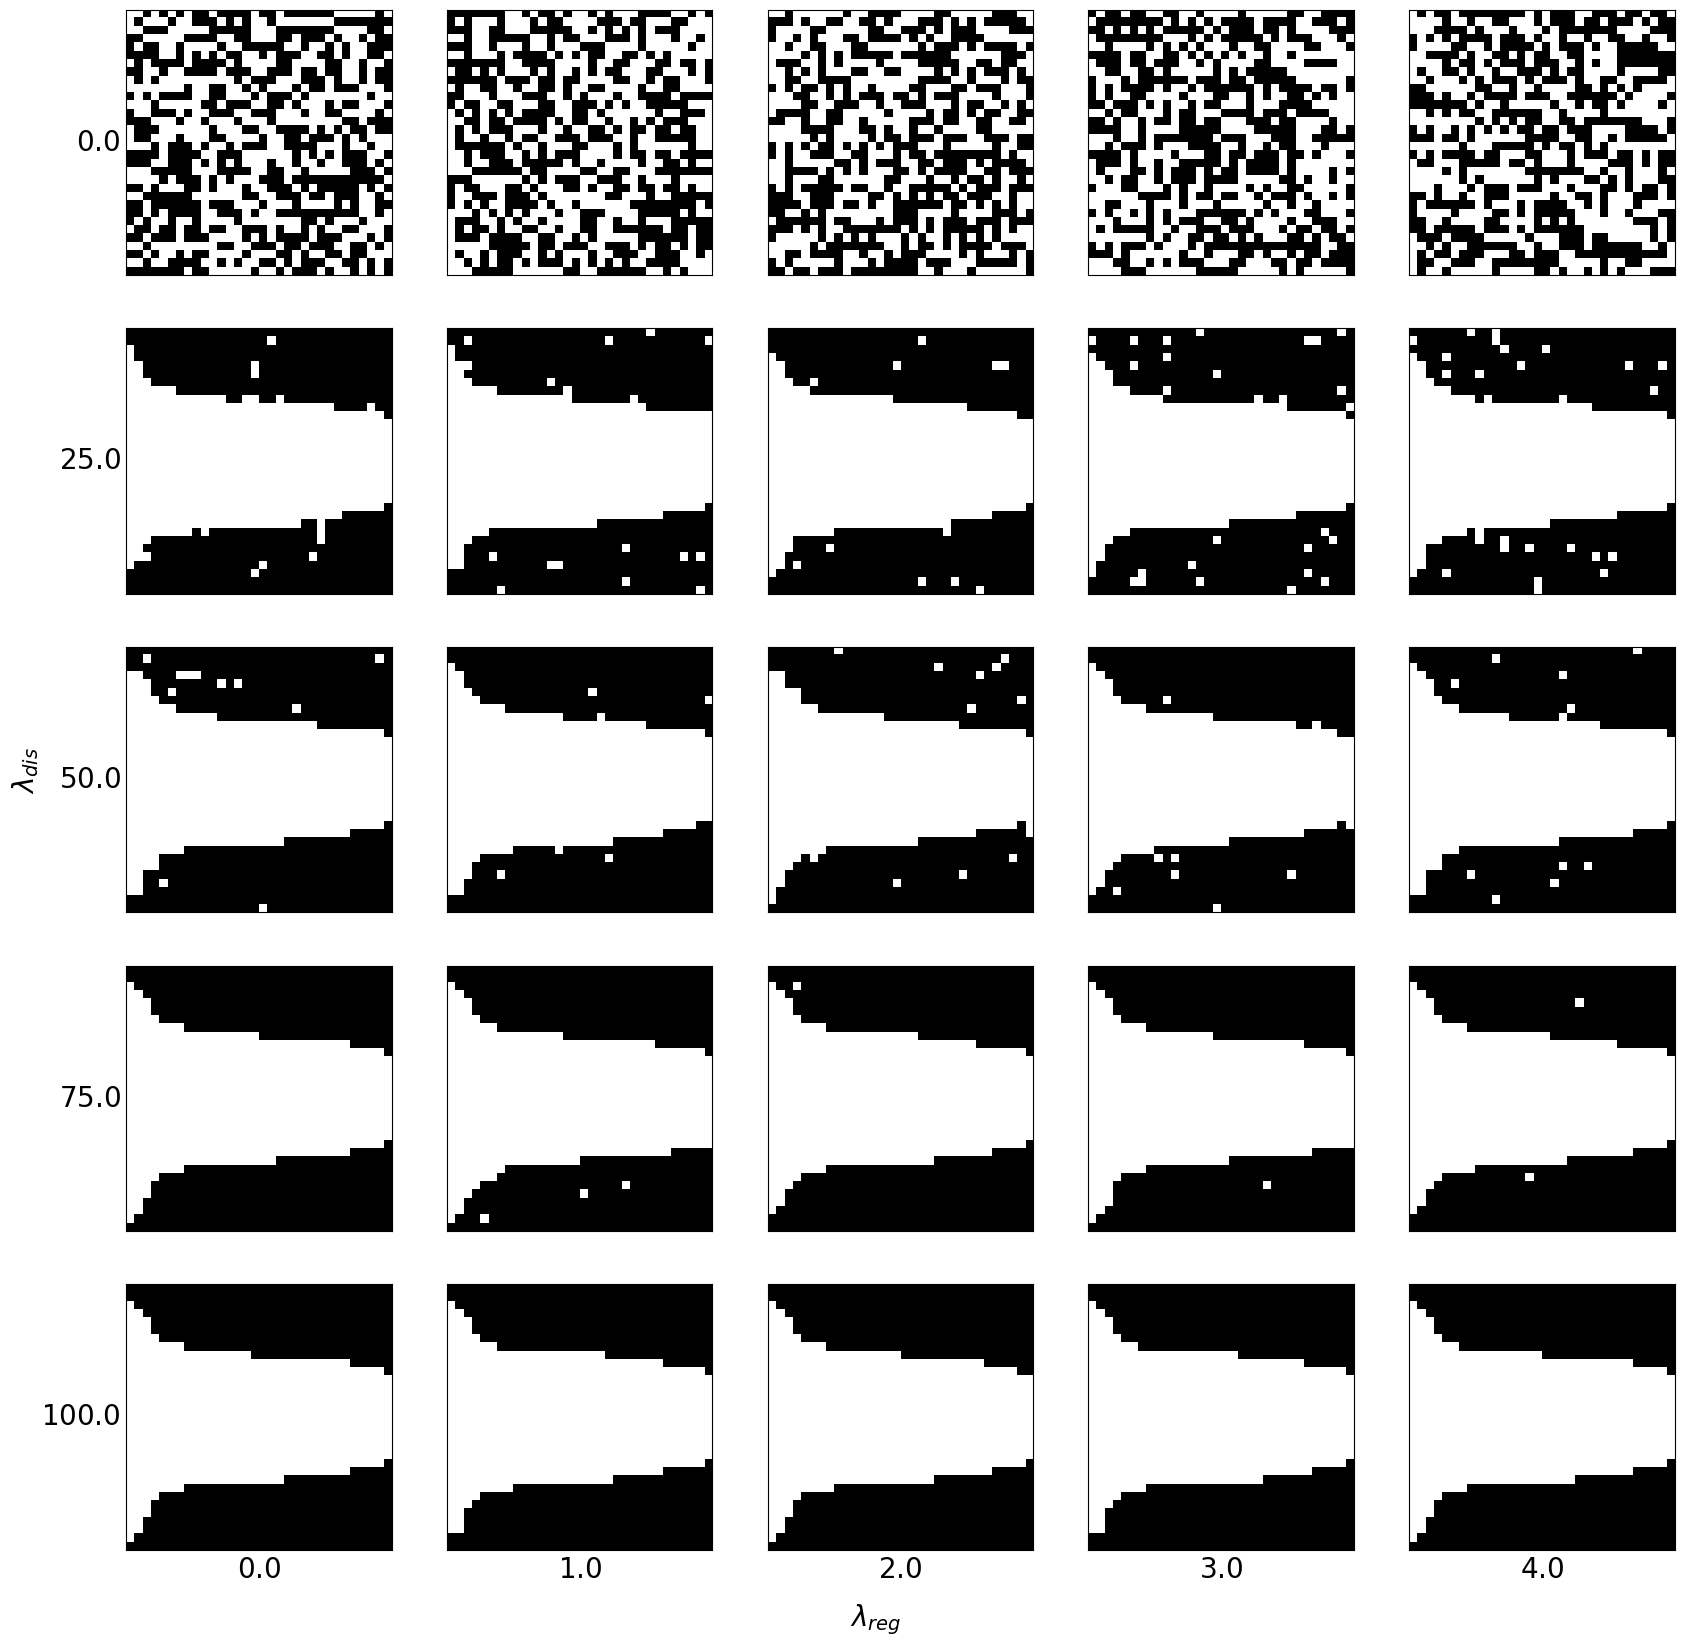

In [ ]:
fig, axes = plt.subplots(n_steps_dis, n_steps_reg, figsize=(4 * n_steps_reg, 4 * n_steps_dis))

for i in range(n_steps_dis):
    for j in range(n_steps_reg):

        index = i * n_steps_reg + j
        ax = axes[i, j]


        char_func = char_funcs[index].reshape(n_elem_for_width,n_elem_for_height).T
        cax = ax.imshow(char_func, cmap='gray', origin='lower') 

        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        
        if j == 0:
            ax.set_ylabel(f'${lambda_dis_values[i]}$', fontsize=20, rotation=0, ha='right', va='center')

        if i == n_steps_dis - 1:
            ax.set_xlabel(f'${lambda_reg_values[j]}$', fontsize=20, ha='center', va='top')

fig.text(0.075, 0.5, r'$\lambda_{dis}$', va='center', ha='center', rotation='vertical', fontsize=20)
fig.text(0.5, 0.075, r'$\lambda_{reg}$', va='center', ha='center', fontsize=20)
fig.savefig(os.path.join(output_path,"dis_reg.png"), dpi=300, bbox_inches='tight')
tikzplotlib.save(os.path.join(output_path,"dis_reg.tex"))
plt.show()